<a href="https://colab.research.google.com/github/polkadot21/cyberwest/blob/master/Min_Max_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

import plotly.express as px
import plotly.graph_objects as go

In [0]:
#random array, x[0] = 1, 
#x[i] = x[i-1] + random.uniform(-1, 1)
def random_array(M):
    random.seed(42)
    N=1024
    x = range(N)
    y = np.zeros(N*M)
    y[0] = 1
    for i in range(1, N*M):
        y[i] = y[i-1] + random.uniform(-1, 1)
    
    return y

In [0]:
#local maxima/minima of random_array M*1024 
#with distance between extrema > 3
#changing MAXs and MINs
#with T*std so that there are approx. 10 extrema in N=1024

def extrema(arr, M=3000):
    #arr = random_array(M)
    #flag variable
    found_min = False
    found = False
    #1/4 of std 
    x = 3
    T = 0.16
    Y_last = 0
    #distance between extrema >3
    dist = x+1
    Ymax = np.zeros(len(arr))
    Ymin = np.zeros(len(arr))
    #T*std
    D = T*np.std(arr[:-(len(arr)-1)] - arr[0:])
    for i in range(1, len(arr)-1):
        #print(D)
        #dist > 3 
        if dist > x:
            #decides to start with MAX or MIN at the beginning of the search
            if found_min or not found:
                if arr[i] > arr[i-1] and arr[i] > arr[i+1]:
                    #whether or not the difference between the last extremum and a new one is more than T.std
                    if np.abs(arr[i] - Y_last) >=D:
                        dist = 1
                        Ymax[i] = 1
                        found = True
                        found_min = False
                        Y_last = arr[i]
                    else:
                        i+=1
                    
            if not found_min or not found:
                if arr[i] < arr[i-1] and arr[i] < arr[i+1]:
                    if np.abs(arr[i] - Y_last) >= D:
                        dist = 1
                        Ymin[i] = 2
                        found = True
                        found_min = True
                        Y_last = arr[i]
                    else:
                        i+=1
        else:
            dist+=1
    #Y_mean = the number of extrema in N=1024       
    Y_mean = np.sum(np.r_[Ymax, Ymin])/M
    Y = Ymax+Ymin
    return Ymax, Ymin, Y_mean, Y

In [0]:
#M = 100
x = random_array(100)
X = x.reshape(-1, 1)
ymax, ymin, ymean, y = extrema(x, 100)

In [0]:
# -------- Train - Test-------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# ---------Split train into train-val--------
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [0]:
#-----Scale-----
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
#-----SMOTE-------
X_resampled, y_resampled = sm.fit_sample(X_train, y_train.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [0]:
#class_dist for each class
def get_class_distribution(obj):
    count_dict = {
        "no": 0,
        "max": 0,
        "min": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['no'] += 1
        elif i == 1: 
            count_dict['max'] += 1
        elif i == 2: 
            count_dict['min'] += 1
                   
        else:
            print("Check classes.")
            
    return count_dict

In [15]:
print("Train:", get_class_distribution(y_resampled))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'no': 72958, 'max': 72958, 'min': 72958}
Test : {'no': 20266, 'max': 107, 'min': 107}
Val  : {'no': 8106, 'max': 43, 'min': 43}


Text(0.5, 1.0, 'Class Distribution in Test Set')

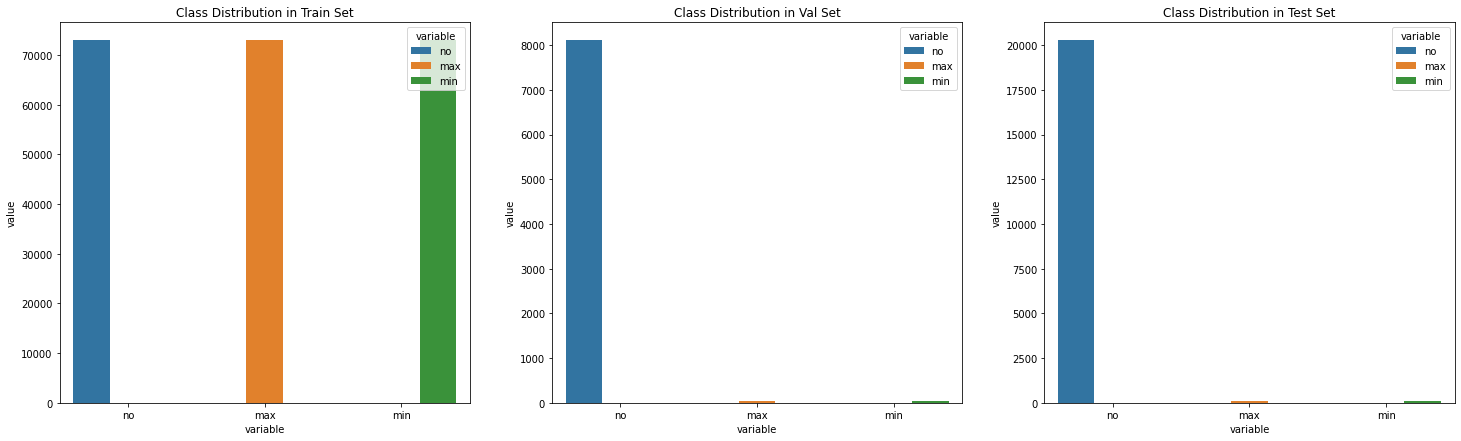

In [18]:
#plot class dist 
#y_train after resampling

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_resampled)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


In [0]:

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_resampled).float(), torch.from_numpy(y_resampled).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [0]:
#params

EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = 1
NUM_CLASSES = 3

In [0]:
#loader

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE) #, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [0]:
class Min_Max_Classification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(Min_Max_Classification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [27]:
#cpu and gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:

model = Min_Max_Classification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

print(model)

#multiclass critretion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Min_Max_Classification(
  (layer_1): Linear(in_features=1, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
#accuracy

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [0]:

accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [35]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


KeyboardInterrupt: ignored

In [0]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [0]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [0]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [25]:
print(confusion_matrix(y_test, y_pred_list))

[[114  12  64]
 [  4   0   3]
 [  1   1   6]]


In [26]:
print(classification_report(y_test, y_pred_list, target_names=["0", "1","2"]))


              precision    recall  f1-score   support

           0       0.96      0.60      0.74       190
           1       0.00      0.00      0.00         7
           2       0.08      0.75      0.15         8

    accuracy                           0.59       205
   macro avg       0.35      0.45      0.30       205
weighted avg       0.89      0.59      0.69       205

